# TVM Workshop [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-ei-eda/tvm-workshop/blob/main/TVM_Workshop.ipynb)

Interactive notebook introducing the essentials of TVM, a machine learning compiler framework.

## 1. Prerequisites

### 1.1 Notebook Environment

**Jupyter Notebook**
If running this notebook locally (e.g. not in Google Colab) some initial steps have to be done to get started:
- Create & enter virtual Python environment
- Start jupyter notebook server

Allow reloading modules without kernel restarts

In [1]:
%load_ext autoreload
%autoreload 2

Google Colab provides a *Table of contents* feature in the left sidebar which should be very useful for navigating between the sections of the Notebook. Indvidual seconds can be collapsed for getting a better overview. The sidebar can also be used to access the *Files* explorer. Feels free to look into any of the files used in the following steps. Here you can also download the generated files at the end of each section.

### 1.2 Python Dependencies

Start with installing with TVM's prebuild python package.

*Warning:* This is a nightly release and thing might break at some point in time!

In [2]:
!pip install tlcpack-nightly -f https://tlcpack.ai/wheels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://tlcpack.ai/wheels
     |████████████████████████████████| 43.2 MB 434 kB/s 


In [3]:
!pip install tflite==2.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 71 kB 180 kB/s 


Python imports

In [4]:
import os
import tarfile
from pathlib import Path

import tflite

from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

import tvm
from tvm import relay, transform, te
from tvm.contrib import graph_executor
from tvm.contrib.download import download_testdata

### 1.3 Example Model

Let's define a utility for later use.

In [5]:
def extract(path):
    if path.endswith("tgz") or path.endswith("gz"):
        dir_path = os.path.dirname(path)
        tar = tarfile.open(path)
        tar.extractall(path=dir_path)
        tar.close()
    else:
        raise RuntimeError("Could not decompress the file: " + path)

For demonstration purposes we use a modelnet v1 model in the following. The model format is TFLite, but the following steps work in a similar way for any other supported modem types such as ONNX, TF,...

In [6]:
model_url = "http://download.tensorflow.org/models/mobilenet_v1_2018_08_02/mobilenet_v1_1.0_224.tgz"

# Download model tar file and extract it to get mobilenet_v1_1.0_224.tflite
model_path = download_testdata(model_url, "mobilenet_v1_1.0_224.tgz", module=["tf", "official"])
model_dir = os.path.dirname(model_path)
extract(model_path)

# Now we can open mobilenet_v1_1.0_224.tflite
tflite_model_file = os.path.join(model_dir, "mobilenet_v1_1.0_224.tflite")
tflite_model_buf = open(tflite_model_file, "rb").read()

# Get TFLite model from buffer
tflite_model = tflite.Model.GetRootAsModel(tflite_model_buf, 0)

### 1.4 Test Data

As we are dealing with an image classification model, let's shortly visualize the deataset we are dealing with by extracting an image.

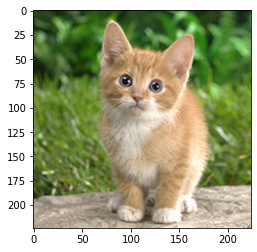

input (1, 224, 224, 3)


In [7]:
image_url = "https://github.com/dmlc/mxnet.js/blob/main/data/cat.png?raw=true"
image_path = download_testdata(image_url, "cat.png", module="data")
resized_image = Image.open(image_path).resize((224, 224))
plt.imshow(resized_image)
plt.show()
image_data = np.asarray(resized_image).astype("float32")

# Add a dimension to the image so that we have NHWC format layout
image_data = np.expand_dims(image_data, axis=0)

# Preprocess image as described here:
# https://github.com/tensorflow/models/blob/edb6ed22a801665946c63d650ab9a0b23d98e1b1/research/slim/preprocessing/inception_preprocessing.py#L243
image_data[:, :, :, 0] = 2.0 / 255.0 * image_data[:, :, :, 0] - 1
image_data[:, :, :, 1] = 2.0 / 255.0 * image_data[:, :, :, 1] - 1
image_data[:, :, :, 2] = 2.0 / 255.0 * image_data[:, :, :, 2] - 1
print("input", image_data.shape)

## 2. TVM Flow

After everything is setup, the actual tutorial can begin. It is structured in a mostly sequencial way and (if applicable) covers the required steps for using TVM on the host (i.e. a powerful machine) as well es on an constrained microcontroller (i.e. using an ARM core).

### 2.1 TVM Frontend

TVM's frontend loads a given model and converts it into the high level Relay language.

Provide information on the input tensors (Name, DataType and Shape)

In [8]:
input_tensor = "input"
input_shape = (1, 224, 224, 3)
input_dtype = "float32"

Convert TFlite Model to Relay IR and extract the constant parameters for later use.

In [9]:
mod, params = relay.frontend.from_tflite(
    tflite_model, shape_dict={input_tensor: input_shape}, dtype_dict={input_tensor: input_dtype}
)

The **Section 2.5** where we will have a look into the files generated by TVM, we can inspect the RelayIR of our model as well!

### 2.2 TVM Transformations

Let's apply Transformations to the model.

TFLite models typically use the `NHWC` format to store the weights of a convolutional layer. However, in some situations (especially when performing autotuning) a schedule using a `HCHW` layout can be more efficient. The following code, therefore, applies passes to the RelayIR Module, which transform the weights.

In [10]:
desired_layout = "NCHW"
desired_layouts = {
    "nn.conv2d": [desired_layout, "default"],
    "qnn.conv2d": [desired_layout, "default"],
}

# Convert the layout of the graph where possible.
seq = transform.Sequential(
    [
        relay.transform.RemoveUnusedFunctions(),
        relay.transform.ConvertLayout(desired_layouts),
    ]
)

with transform.PassContext(opt_level=3):
    mod = seq(mod)

### 2.3 TVM Configuration

Depending of the type of device we are dealing with, we have to provide different information to the TVM compilation pipeline to achieve the expected results. For testing and prototyping during development on a development machine the LLVM-based approach is the easiest. However if we want to deploy our model on a microcontroller in the end, a different approach is required.

#### 2.3.1 Configure for host

The most straightforward way to get started with TVM is using the plain `llvm` target. A a later point in time we can add additional information to our target, to make use of target-specific optimizations which are implemented in TVM.

In [11]:
TARGET = "llvm"

#### 2.3.1 Configure for Microcontroller

Next, let's use MicroTVM target based on C backend instead of LLVM. We are using the CRT runtime in combination with the AoT executor as it is more lightweight compared to the full C++ runtime.

While the `graph` executor (which is commented out in the following) requires a lot more ressources in terms of memory and CPU Cycles, it has some advantages which might want to make use of, especially for debugging purposes.

In [12]:
MICRO_TARGET = tvm.target.target.micro("host")  # resolves to "c -device=micro"

# Configuration for AoT Executor based on CRT runtime
MICRO_RUNTIME = tvm.relay.backend.Runtime("crt", {"system-lib": False})
MICRO_EXECUTOR = tvm.relay.backend.Executor(
    "aot", {"interface-api": "c", "unpacked-api": True, "link-params": True}
)

# Configuration for Graph Executor based on CRT runtime
# MICRO_RUNTIME = tvm.relay.backend.Runtime("crt", {"system-lib": True})
# MICRO_EXECUTOR = tvm.relay.backend.Executor(
#     "graph", {"link-params": True}
# )

These pass configuration options will be passed to the `relay.build()` function in a later step.

In [13]:
 MICRO_CFG = {
    "tir.disable_vectorize": True,  # Vectorization is not supported by non-LLVM targets
    # Enable improved memory planning algorithms
    "tir.usmp.enable": True,  
    "tir.usmp.algorithm": "hill_climb",
}

### 2.4 TVM Compilation Pipeline

Now, we can build the Model which can be achieved using just two lines of code.

While this step looks pretty simple, it actually invoces the whole compilation pipeline provided by TVM. Depending on the complexity of the model and the enabled features, it might take a couple of seconds to complete.

#### 2.4.1 Compile for Host

Here the default C++ based runtime and graph executor is used implicitly.

In [14]:
with transform.PassContext(opt_level=3):
    lib = relay.build(mod, TARGET, params=params)

/usr/local/lib/python3.7/dist-packages/tvm/driver/build_module.py:268: UserWarning: target_host parameter is going to be deprecated. Please pass in tvm.target.Target(target, host=target_host) instead.
  "target_host parameter is going to be deprecated. "


#### 2.4.2 Compile for Microcontroller

Do not forget to explicitly pass the chosen executor and runtime to the `relay.build()` function.

In [15]:
with tvm.transform.PassContext(opt_level=3, config=MICRO_CFG):
    micro_lib = relay.build(mod, target=MICRO_TARGET, runtime=MICRO_RUNTIME, executor=MICRO_EXECUTOR, params=params)

### 2.5 TVM Artifacts

In the following step we export our codegen artifacts to investigate the generated files. 

#### 2.5.1 Shared Object Library

Here we export a shared object file containing the libray TVM has generated for our host.

In [17]:
shared_object_file = Path("module.so")
lib.export_library(shared_object_file)

As this object file is not human-readable, we can not really inspect it. However we can load such model back into TVM very easily is shown here:

In [18]:
loaded_lib = tvm.runtime.load_module(shared_object_file)

#### 2.5.2 Model Library Format (MLF)



For MicroTVM targets we are interested in the Model Library Format (MLF) artifact as it contains the sources required to build our target software.

In [19]:
model_library_format_path = Path("mlf")
tvm.micro.export_model_library_format(micro_lib, f"{model_library_format_path}.tar")

PosixPath('mlf.tar')

Extract the MLF archive

In [20]:
model_library_format_path.mkdir(exist_ok=True)
tar = tarfile.open(f"{model_library_format_path}.tar").extractall(
    model_library_format_path
)

In the following, a truncated version of the contents of the `mlf.tar` archive generated by the previous commands is given.

```
.
├── codegen
│   └── host
│       ├── include
│       │   └── tvmgen_default.h
│       └── src
│           ├── default_lib0.c
│           └── default_lib1.c
├── metadata.json
├── parameters
│   └── default.params
├── runtime
│   └── ...
└── src
    └── default.relay
```

- `codegen/host/` Contains the main artifacts of the TVM compilation flow:
  - The generated kernels e.g. `src/default_lib1.c`
  - Interfacing code for calling the generated kernels, as well as for passing model inputs and outputs, can be found in `include/tvmgen_default.h` and `src/default_lib0.c`
  - *Optional:* If parts of the model are processed by i.e. a hardware accelerator, there may also exist `src/default_lib2.c` etc.
- `metadata.json` Contains some information about the model and used workspace buffers (only used by some executors).
- `parameters/default.params` Binary file containing the data of all constant tensors used in the model. (Ignored by AoT executor, which automatically includes them into the kernel sources.)
- `runtime/` Contains the additional sources required to make use of the generated kernels using the chosen executor/runtime. (here: TVM minimal crt and third party libraries)
- `src/relay.txt` The intermediate representation of the model graph before lowering (might be useful for debugging).


Feel free to look into the generated files in the `mlf` directory by yourself!

### 2.6 TVM Model Execution/Evaluation

After building the model, we definetly want to test it to check if it produces the expected results. In addition we might want to benchmark it to determine the inference performance.

#### 2.6.1 Execution on host

Here we use the model previously loaded from the share object library file.

In [24]:
# Create a runtime executor module
module = graph_executor.GraphModule(loaded_lib["default"](tvm.cpu()))

# Feed input data
module.set_input(input_tensor, tvm.nd.array(image_data))

# Run
module.run()

# Get output
tvm_output = module.get_output(0).numpy()
tvm_output

array([[1.3275057e-07, 1.2741729e-06, 4.9942050e-06, ..., 7.6598380e-06,
        1.6978064e-04, 4.6119548e-04]], dtype=float32)

Here we do some final classification steps

In [25]:
# Load label file
label_file_url = "".join(
    [
        "https://raw.githubusercontent.com/",
        "tensorflow/tensorflow/master/tensorflow/lite/java/demo/",
        "app/src/main/assets/",
        "labels_mobilenet_quant_v1_224.txt",
    ]
)
label_file = "labels_mobilenet_quant_v1_224.txt"
label_path = download_testdata(label_file_url, label_file, module="data")

# List of 1001 classes
with open(label_path) as f:
    labels = f.readlines()

# Convert result to 1D data
predictions = np.squeeze(tvm_output)

# Get top 1 prediction
prediction = np.argmax(predictions)

# Convert id to class name and show the result
print("The image prediction result is: id " + str(prediction) + " name: " + labels[prediction])

The image prediction result is: id 283 name: tiger cat



#### 2.6.1 Execution on microcontroller

To run our model on a MCU, we will use the MicroTVM deployment framework which will be introduced later in **Section 2.10**.

### 2.7 Command-line interface

The previously shown steps can also be accomplished using a simplified command line interface named TVMC. Here are some usage examples for reference:

```
# Host
tvmc compile mobilenet_v1_1.0_224.tflite --output lib.tar --target llvm
tvmc run lib.tar --fill-mode random --print-time --print-top 10

# Microcontroller
tvmc compile mobilenet_v1_1.0_224.tflite --output mlf.tar \
    --target c --runtime crt --executor-aot-interface-api c \
    --executor=aot --executor-aot-unpacked-api=1 --desired-layout NCHW \
    --output-format mlf --pass-config tir.disable_vectorize=1 \
    --pass-config tir.usmp.enable=1 --pass-config tir.usmp.algorithm=hill_climb
tvmc micro [create|build|flash] ...
tvmc run -device micro ...
```

A `--profile` flag is also available for the `tvmc run` command which helps to analyse the per-layer inference times of our model.

### 2.8 Auto-tuning

While TVM can optimize a model for a given target device by providing additional information such as the number of cores are the used target architecture. However the default or often called "fallback"-schedules are the the name suggest often suboptimal given a random model/target combination. To improve the inference performance in a automated-fashion, TVM provides several interfaces, including AutoTVM and AutoScheduler which are the most established ones and demonstrated int he following.

For the sake of simliticy we use the TVMC command line interface for the following cells.

#### 2.8.1 Tuning for host using AutoTVM

AutoTVM extracts a list of tunable tasks of the model and tunes the one after each other by searching a tuning-space given by manually written schdule template for the operators in am model. A JSON long file with the results in generated during the tuning procedure.

*Hint:* The printed warning can be ignored. They are quite annoying and hopefully removed in the near future.

In [26]:
!tvmc tune $tflite_model_file --target llvm --output autotvm_records.json --desired-layout NCHW --trials 100 --tuner ga

/usr/local/lib/python3.7/dist-packages/tvm/target/target.py:261: UserWarning: target_host parameter is going to be deprecated. Please pass in tvm.target.Target(target, host=target_host) instead.
  "target_host parameter is going to be deprecated. "
[15:55:40] /workspace/tvm/src/relay/transforms/convert_layout.cc:99: Warning: Desired layout(s) not specified for op: nn.avg_pool2d
/usr/local/lib/python3.7/dist-packages/tvm/driver/build_module.py:268: UserWarning: target_host parameter is going to be deprecated. Please pass in tvm.target.Target(target, host=target_host) instead.
  "target_host parameter is going to be deprecated. "
[Task  1/20]  Current/Best:    0.00/   0.00 GFLOPS | Progress: (0/5) | 0.00 s/usr/local/lib/python3.7/dist-packages/tvm/driver/build_module.py:268: UserWarning: target_host parameter is going to be deprecated. Please pass in tvm.target.Target(target, host=target_host) instead.
  "target_host parameter is going to be deprecated. "
/usr/local/lib/python3.7/dist-pa

#### 2.8.2 Tuning for host using AutoScheduler

The AutoScheduler is more powerful (as it can derive suitable schedules for a given operator automatically), however this often introduces an overhead in total tuning time due to the more complex tuning infrastructure. The generated results are again written into a JSON file. 

In [27]:
!tvmc tune $tflite_model_file --target llvm --output autoscheduler_records.json --desired-layout NCHW --trials 100 --enable-autoscheduler

/usr/local/lib/python3.7/dist-packages/tvm/target/target.py:261: UserWarning: target_host parameter is going to be deprecated. Please pass in tvm.target.Target(target, host=target_host) instead.
  "target_host parameter is going to be deprecated. "
Get devices for measurement successfully!
[16:01:27] /workspace/tvm/src/relay/transforms/convert_layout.cc:99: Warning: Desired layout(s) not specified for op: nn.avg_pool2d
/usr/local/lib/python3.7/dist-packages/tvm/driver/build_module.py:268: UserWarning: target_host parameter is going to be deprecated. Please pass in tvm.target.Target(target, host=target_host) instead.
  "target_host parameter is going to be deprecated. "
----------------------------------------------------------------------
------------------------------  [ Task Scheduler ]
----------------------------------------------------------------------
|  ID  |                       Task Description                        | Latency (ms) | Speed (GFLOPS) | Trials |
---------------

#### 2.8.3 Tuning for Microcontrollers

Tuning support for MicroTVM using TVMC is not upstream yet.

#### 2.8.4 Using the tuning results for optimizing a model

Do not forget to pass the generated tuning results to the TVM Compilation pipeline to make use of the tuning artifacts. Using the TVMC command line this can i.e. be achieved as follows by adding `--tuning-records autotvm_records.json` to the command line arguments



### 2.9 Accelerator Support

The Bring-your-own-Codegen (BYOC) interface allows extending TVM with custom backends using medium efforts. It allows integrating external accelerators into the TVM compilation as well as using specialized kernel libraries such as CMSIS-NN for ARM targets.

As the development of BYOC backends is mostly based on C++, no example is provides here. Instead here is a short example for how to use the existing BYOC backends in TVM:

Update the TVMC command line arguments to include `--target cmsis-nn,c --target-cmsis-nn-mcpu=cortex-m55` which will enable the MVE-Extension based ARM functions in the CMSIS-NN library.

## 2.10 Deployment to Microcontrollers

#### 2.10.1 Deployment without MicroTVM

The exported MLF artifact in the previous step contains all the relevant sources to build a static library for our TVM model which can be linked to any Target SW executable in the following development step.

### 2.10.2 Deployment via MicroTVM

MicroTVM provides an interface to compile/flash/run/tune models for baremetal microcontrollers in a straightforward fashion. The MicroTVM interface is available from Python or using the `tvmc micro` subcommand on the command line (as mentioned earlier in **Section 2.7**).

Why using one of the existing MicroTVM Platforms such as ZephyrOS or Arduino, many possible targets can be used with TVM out of the box.

As MicroTVM depends on real hardware targets, an interactive example can not be made available in this Colab notebook.